# Tutorial for Pipefunc Package

The pipefunc package is a Python library designed to simplify the creation and execution of function pipelines.
It allows you to define functions as pipeline steps, automatically managing dependencies and execution order.
In this tutorial, we will guide you through the key features of pipefunc, including sequential and parallel execution, map-reduce operations, and advanced functionalities.

This page is [a Jupyter notebook](https://github.com/pipefunc/pipefunc/blob/main/example.ipynb), executed and rendered in [the official documentation](https://pipefunc.readthedocs.io/en/latest/tutorial).

## High level overview

1. The pipefunc package allows to create reusable and callable pipelines.
1. A `Pipeline` contains a list of `PipeFunc` objects.
1. At its core, these `PipeFunc` objects only contain a function and an output name.
1. You can create a `PipeFunc` object directly or using the `@pipefunc` decorator.
1. The `Pipeline` will automatically connect all functions based on the output names and function inputs.

---

## Building a Simple Pipeline

Let's start by importing `pipefunc` and `Pipeline` from the `pipefunc` module.


In [1]:
from pipefunc import PipeFunc, Pipeline, pipefunc

We then define some functions using the `@pipefunc` decorator.
The `@pipefunc` decorator turns these functions into pipeline steps.
For each function, we specify an `output_name` which will be used to refer to the output of that function in the pipeline.

In [2]:
@pipefunc(output_name="c")
def f(a, b):
    return a + b


@pipefunc(output_name="d")
def g(b, c, x=1):  # "c" is the output of f
    return b * c * x


@pipefunc(output_name="e")
def h(c, d, x=1):  # "d" is the output of g
    return c * d * x

We now have three functions `f`, `g`, and `h`, which we can use to build a pipeline.
We create a `Pipeline` object passing the list of functions.
We can also enable debugging, profiling, and caching for the entire pipeline:

In [3]:
pipeline = Pipeline(
    [f, g, h],
    debug=True,  # optionally print debug information
    profile=True,  # optionally profile the pipeline
    cache_type="hybrid",  # optionally cache the pipeline
)

Now, we have a pipeline that only requires `a` and `b` as inputs and uses the outputs of the functions and automatically passes them as inputs to the next function.

Don't want to use the `@pipefunc` decorator? No problem! You can create a `PipeFunc` object directly:

In [4]:
@pipefunc(output_name="c")
def f(a, b):
    return a + b


# is equivalent to


def f(a, b):
    return a + b


f = PipeFunc(f, output_name="c")


---

## Visualizing the Pipeline

You can visualize your pipeline using the `visualize()` method, and print the nodes in the graph using the `graph.nodes` attribute.

:::{admonition} Interactive visualization with [`graphviz-anywidget`](https://github.com/pipefunc/graphviz-anywidget)
:class: note, dropdown

In a live Jupyter notebook, the output below allows interaction with the pipeline visualization.
 
You will be able to zoom by scrolling, pan by dragging the image, and click on nodes to highlight all connected nodes. Click Escape to reset the view.
:::

In [ ]:
print("Graph nodes:", pipeline.graph.nodes)
pipeline.visualize()

Graph nodes: [PipeFunc(f), 'a', 'b', PipeFunc(g), 'x', PipeFunc(h)]
{} c
{} d
{} e
Hints in viz {}


---

## Executing the Pipeline

There are two ways to execute the pipeline:

1. Call the pipeline as a function (***sequentially***) and get a specific output:
   - `pipeline(output_name, **kwargs)`
   - `pipeline.run(output_name, kwargs)`
2. Evaluate the entire pipeline (***parallel***) including map-reduce operations:
   - `pipeline.map(kwargs)`

We start with calling the pipeline directly and then introduce the `map` method.

See [this FAQ section](project:faq.md#run-vs-map) for more information on the difference between `run` and `map`.

### Using `pipeline(...)` (Sequential Execution)

If the pipeline has a unique leaf node (single final output), then we can directly call the pipeline object with the input arguments.

In [6]:
pipeline(a=1, b=2)

2025-01-13 19:41:11.475036 - Function returning 'c' was invoked as `f(a=1, b=2)` and returned `3`. The execution time was 7.74e-04 seconds on average.
2025-01-13 19:41:11.475805 - Function returning 'd' was invoked as `g(x=1, b=2, c=3)` and returned `6`. The execution time was 1.34e-04 seconds on average.
2025-01-13 19:41:11.476201 - Function returning 'e' was invoked as `h(x=1, c=3, d=6)` and returned `18`. The execution time was 1.40e-04 seconds on average.


18

In [7]:
# The above returns the output for:
pipeline.unique_leaf_node

PipeFunc(h)

We can also specify the desired output as the first argument of the pipeline function:


In [8]:
print("`e` is:", pipeline("e", a=1, b=2))
print("`d` is:", pipeline("d", a=1, b=2))

2025-01-13 19:41:11.700447 - Function returning 'c' was invoked as `f(a=1, b=2)` and returned `3`. The execution time was 8.21e-04 seconds on average.
2025-01-13 19:41:11.702442 - Function returning 'd' was invoked as `g(x=1, b=2, c=3)` and returned `6`. The execution time was 2.15e-04 seconds on average.
2025-01-13 19:41:11.703611 - Function returning 'e' was invoked as `h(x=1, c=3, d=6)` and returned `18`. The execution time was 2.55e-04 seconds on average.
`e` is: 18
2025-01-13 19:41:11.704972 - Function returning 'c' was invoked as `f(a=1, b=2)` and returned `3`. The execution time was 6.50e-04 seconds on average.
2025-01-13 19:41:11.706251 - Function returning 'd' was invoked as `g(x=1, b=2, c=3)` and returned `6`. The execution time was 3.32e-04 seconds on average.
`d` is: 6


### Using `pipeline.run(...)` (Sequential Execution)

Similar to calling the `pipeline` object, we can use the `run` method to execute the pipeline.

> Note: The `pipeline(...)` call is just a wrapper around the `run` method.


In [9]:
result = pipeline.run("e", kwargs={"a": 1, "b": 2})
print(result)

2025-01-13 19:41:11.842863 - Function returning 'c' was invoked as `f(a=1, b=2)` and returned `3`. The execution time was 6.31e-04 seconds on average.
2025-01-13 19:41:11.844270 - Function returning 'd' was invoked as `g(x=1, b=2, c=3)` and returned `6`. The execution time was 3.06e-04 seconds on average.
2025-01-13 19:41:11.844961 - Function returning 'e' was invoked as `h(x=1, c=3, d=6)` and returned `18`. The execution time was 2.53e-04 seconds on average.
18


or get _*all*_ function outputs and inputs by specifying `full_output=True`:


In [10]:
result = pipeline.run("e", kwargs={"a": 1, "b": 2}, full_output=True)
print(result)

2025-01-13 19:41:12.028466 - Function returning 'c' was invoked as `f(a=1, b=2)` and returned `3`. The execution time was 5.57e-04 seconds on average.
2025-01-13 19:41:12.029241 - Function returning 'd' was invoked as `g(x=1, b=2, c=3)` and returned `6`. The execution time was 3.07e-04 seconds on average.
2025-01-13 19:41:12.029476 - Function returning 'e' was invoked as `h(x=1, c=3, d=6)` and returned `18`. The execution time was 2.07e-04 seconds on average.
{'a': 1, 'b': 2, 'c': 3, 'd': 6, 'e': 18}


### Using `pipeline.map(...)` (Parallel Execution)

`pipeline.map` allows you to execute your pipeline over a set of inputs in parallel.

> **Note:** The `mapspec` argument in the `@pipefunc` decorator defines how inputs are mapped to outputs.

> **Note:** ⚠️ The mapping computation of the pipeline is done in parallel using the `concurrent.futures.ProcessPoolExecutor` whenever `pipeline.map(..., parallel=True)` (default).


In [11]:
@pipefunc(output_name="y", mapspec="x[i] -> y[i]")
def double_it(x: int) -> int:
    assert isinstance(x, int)
    return 2 * x


pipeline_double = Pipeline([double_it])

inputs = {"x": [1, 2, 3, 4, 5]}
run_folder = "my_run_folder"  # save the results in this folder
result = pipeline_double.map(inputs, run_folder)
print(result["y"].output)

[2 4 6 8 10]


**Syntax of `mapspec`:**

```
input1[i], input2[j] -> output[i, j]
```

- **`i` and `j`** are indices over which the function maps.
- **`input1[i]`** means the function will receive `input1` at index `i`.
- **`output[i, j]`** means the function will produce `output` with indices `i` and `j`.

Instead of defining `mapspec` manually, you can use the `add_mapspec_axis` method on the pipeline object:

In [12]:
# Take `pipeline` defined above and add a 2D mapspec
pipeline2 = pipeline.copy()
pipeline2.debug = False  # Turn off debugging print statements
pipeline2.add_mapspec_axis("a", axis="i")
pipeline2.add_mapspec_axis("b", axis="j")
run_folder = "my_run_folder"
result = pipeline2.map({"a": [1, 2], "b": [3, 4]}, run_folder, show_progress=True)
result["e"].output  # This is now a 2D array

array([[48, 100],
       [75, 144]], dtype=object)

The methods above will automatically generate the `mapspec` for you, which is now:

In [13]:
pipeline2.mapspecs_as_strings

['a[i], b[j] -> c[i, j]',
 'c[i, j], b[j] -> d[i, j]',
 'd[i, j], c[i, j] -> e[i, j]']

The `pipeline.map` method is powerful and can handle complex map-reduce operations, which we will demonstrate next.

#### Map-reduce or fan-in / fan-out operations

The script below demonstrates a two-step pipeline: doubling each integer in an input list, followed by summing all the doubled values.


In [ ]:
import numpy as np

from pipefunc import Pipeline, pipefunc
from pipefunc.typing import Array


@pipefunc(output_name="y", mapspec="x[i] -> y[i]")
def double_it(x: int) -> int:
    assert isinstance(x, int)
    return 2 * x


@pipefunc(output_name="sum")  # no mapspec, so receives y[:] as input
def take_sum(y: Array[int]) -> int:
    assert isinstance(y, np.ndarray)
    return sum(y)


pipeline_map = Pipeline([double_it, take_sum])
pipeline_map.visualize()

{'y': <class 'int'>} y
{'sum': <class 'int'>} sum
Hints in viz {'y': typing.Annotated[numpy.ndarray[typing.Any, numpy.dtype[numpy.object_]], pipefunc.typing.ArrayElementType[int]], 'x': <class 'int'>, 'sum': <class 'int'>}


:::{admonition} What is `mapspec`?
:class: note, dropdown

In `double_it`, `mapspec="x[i] -> y[i]"` specifies that each element `i` of the input array `x` is independently processed to produce the corresponding element `i` in the output array `y`.
Because `take_sum` does not have a `mapspec`, it receives the entire array `y` for aggregation.
:::

Note that the mapspecs are present in the plot. For example, `x` is now `x[i]`.

In [15]:
inputs = {"x": [0, 1, 2, 3]}
run_folder = "my_run_folder"
results = pipeline_map.map(inputs, run_folder=run_folder)

Check the results in the resulting dict

In [16]:
assert results["y"].output.tolist() == [0, 2, 4, 6]
assert results["sum"].output == 12

Or load the outputs from disk

In [17]:
from pipefunc.map import load_outputs

assert load_outputs("y", run_folder=run_folder).tolist() == [0, 2, 4, 6]
assert load_outputs("sum", run_folder=run_folder) == 12

Or also load from disk but as an `xarray.Dataset`:

In [18]:
from pipefunc.map import load_xarray_dataset

load_xarray_dataset(run_folder=run_folder)

<xarray.Dataset> Size: 72B
Dimensions:  (i: 4)
Coordinates:
    x        (i) int64 32B 0 1 2 3
Dimensions without coordinates: i
Data variables:
    y        (i) object 32B 0 2 4 6
    sum      int64 8B 12

## Advanced features

Below are some advanced features of the `pipefunc` package.
You will find more features in the [FAQ](https://pipefunc.readthedocs.io/en/latest/faq/).

---

### Working with Resources Report

The `print_profiling_stats()` method of the `pipeline` provides useful information on the performance of the functions in the pipeline such as CPU usage, memory usage, average time, and the number of times each function was called.
This feature is only available if `profile=True` when creating the pipeline.

In [19]:
# This will print the number of times each function was called
# CPU, memory, and time usage is also reported
pipeline.print_profiling_stats()

Resource Usage Report:
---------+-------------------+-----------------------+--------------+----------------+----------------
Function | Avg CPU Usage (%) | Max Memory Usage (MB) | Avg Time (s) | Total Time (%) | Number of Calls
-------- | ----------------- | --------------------- | ------------ | -------------- | ---------------
f        | 0.00              | 0.00                  | 5.57e-04     | 54.12          | 5              
g        | 0.00              | 0.00                  | 3.07e-04     | 29.79          | 5              
h        | 0.00              | 0.00                  | 2.07e-04     | 16.09          | 4              
---------+-------------------+-----------------------+--------------+----------------+----------------


This report can be beneficial in performance tuning and identifying bottlenecks in your pipeline. You can identify which functions are consuming the most resources and adjust your pipeline accordingly.

You can also look all the stats directly with:


In [20]:
pipeline.profiling_stats

{'f': ProfilingStats(cpu=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), memory=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), time=ResourceStats(num_executions=5, average=5.5730e-04, max=8.6852e-04, std=2.7069e-04)),
 'g': ProfilingStats(cpu=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), memory=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), time=ResourceStats(num_executions=5, average=3.0682e-04, max=5.6602e-04, std=1.6094e-04)),
 'h': ProfilingStats(cpu=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), memory=ResourceStats(num_executions=0, average=0.0000e+00, max=0.0000e+00, std=0.0000e+00), time=ResourceStats(num_executions=4, average=2.0712e-04, max=3.6952e-04, std=1.3144e-04))}

 ---

### Handling Multiple Outputs

Functions can return multiple results at once.
The `output_name` argument allows you to specify multiple outputs by providing a tuple of strings.
By default, this assumes the output is a `tuple`.
However, if you provide a `output_picker` function, you can return any type of object.
As long as the output name can be used to get the desired output from the returned object.

In [ ]:
from pipefunc import Pipeline, pipefunc


# Returns 2 outputs as a tuple: 'c' and 'const'.
@pipefunc(output_name=("c", "const"))
def add_ab(a, b):
    return (a + b, 1)


def get_dict_output(output, key):
    return output[key]


# Function that returns a dictionary, output_picker is used
# to pick out "d" and "e".
@pipefunc(output_name=("d", "e"), output_picker=get_dict_output)
def mul_bc(b, c, x=1):
    return {"d": b * c, "e": x}


# Function returns an object with attributes 'g' and 'h'.
# output_picker is used to pick out 'g' and 'h'.
@pipefunc(output_name=("g", "h"), output_picker=getattr)
def calc_cde(c, d, e, x):
    from types import SimpleNamespace

    return SimpleNamespace(g=c * d * x, h=c + e)


# Define a function add_gh with a single output 'i'.
@pipefunc(output_name="i")
def add_gh(e, g):
    return e + g


# Create a pipeline with the defined functions and visualize it.
pipeline_multiple = Pipeline([add_ab, mul_bc, calc_cde, add_gh])
pipeline_multiple.visualize()

{} ('c', 'const')
{} ('d', 'e')
{} ('g', 'h')
{} i
Hints in viz {}


In [22]:
pipeline_multiple(a=1, b=2, x=3)

57

---

### Using the `renames` Feature

The `renames` attribute in `pipefunc` allows you to rename the inputs and outputs of a function before passing them to the next step in the pipeline.
This can be particularly useful when the same function is used multiple times in a pipeline, or when you want to provide more meaningful names to the inputs and outputs.

In the example below, we demonstrate how to use the `renames` attribute to rename the inputs of a function before they are passed to the next step in the pipeline.

> ⚠️ Instead of using the `@pipefunc` decorator (which creates `pipefunc.PipeFunc` object), we will create `PipeFunc` objects directly and specify the `renames` attribute.


In [23]:
from pipefunc import PipeFunc, Pipeline


def prod(a, b):
    return a * b


def subtract(a, b):
    return a - b


# We're going to use these functions multiple times in the pipeline
functions = [
    PipeFunc(prod, output_name="prod1"),
    PipeFunc(prod, output_name="prod2", renames={"a": "x", "b": "y"}),
    PipeFunc(subtract, output_name="delta1", renames={"a": "prod1", "b": "prod2"}),
    PipeFunc(subtract, output_name="delta2", renames={"a": "prod2", "b": "prod1"}),
    PipeFunc(prod, output_name="result", renames={"a": "delta1", "b": "delta2"}),
]
pipeline_renames = Pipeline(functions)

inputs = {"a": 1, "b": 2, "x": 3, "y": 4}
results = pipeline_renames("result", **inputs)

# Output the results
print("Results:", results)

pipeline_renames.visualize()

Results: -100
{} prod1
{} prod2
{} delta1
{} delta2
{} result
Hints in viz {}


**Explanation**:

1. **Function Definitions**:

   - `prod(a, b)`: Multiples two numbers and returns the result.
   - `subtract(a, b)`: Subtracts `b` from `a` and returns the result.

2. **Pipeline Construction**:

We are just using the `prod` and `subtract` functions multiple times, but change the names of the inputs and outputs to create a pipeline from it.

One can also apply the renames afterwards using the `update_renames` method. Or even to the entire pipeline, like:

In [24]:
pipeline_renames2 = pipeline_renames.copy()
pipeline_renames2.update_renames(
    {
        "a": "aa",
        "b": "bb",
        "x": "xx",
        "y": "yy",
        "result": "final_result",  # Rename the `output_name` of the last function
    },
    update_from="current",  # update from the current renames, not the original
)
pipeline_renames2(aa=1, bb=2, xx=3, yy=4)

-100

Also check out these `Pipeline` methods:

- `Pipeline.update_defaults`
- `Pipeline.update_bound`

and these `PipeFunc` methods:

- `PipeFunc.update_renames`
- `PipeFunc.update_defaults`
- `PipeFunc.update_bound`

---

### Custom Parallelism

By default when `pipeline.map(..., parallel=True)` is used, the pipeline is executed in parallel using the `concurrent.futures.ProcessPoolExecutor`. However, you can also specify a custom executor to control the parallelism of the pipeline execution.

It works with any custom executor that has the `concurrent.futures.Executor` interface, so for example it works with:

- `concurrent.futures.ProcessPoolExecutor`
- `concurrent.futures.ThreadPoolExecutor`
- `ipyparallel.Client().executor()`
- `dask.distributed.Client().get_executor()`
- `mpi4py.futures.MPIPoolExecutor()`
- `loky.get_reusable_executor()`

To just change the number of cores while using the default executor, use

In [25]:
import datetime
import time
from concurrent.futures import ProcessPoolExecutor

from pipefunc import Pipeline, pipefunc


@pipefunc(output_name="double", mapspec="x[i] -> double[i]")
def double_it(x: int) -> int:
    print(f"{datetime.datetime.now()} - Running double_it for x={x}")
    time.sleep(1)
    return 2 * x


@pipefunc(output_name="half", mapspec="x[i] -> half[i]")
def half_it(x: int) -> int:
    print(f"{datetime.datetime.now()} - Running half_it for x={x}")
    time.sleep(1)
    return x // 2


@pipefunc(output_name="sum")
def take_sum(half: np.ndarray, double: np.ndarray) -> int:
    print(f"{datetime.datetime.now()} - Running take_sum")
    return sum(half + double)


pipeline_parallel = Pipeline([double_it, half_it, take_sum])
inputs = {"x": [0, 1, 2, 3]}
run_folder = "my_run_folder"
executor = ProcessPoolExecutor(max_workers=8)  # use 8 processes
results = pipeline_parallel.map(
    inputs,
    run_folder=run_folder,
    parallel=True,
    executor=executor,
    storage="shared_memory_dict",
)
print(results["sum"].output)

2025-01-13 19:41:20.753529 - Running double_it for x=0
2025-01-13 19:41:20.754121 - Running double_it for x=22025-01-13 19:41:20.754160 - Running double_it for x=32025-01-13 19:41:20.753718 - Running double_it for x=1


2025-01-13 19:41:20.757577 - Running half_it for x=02025-01-13 19:41:20.759279 - Running half_it for x=1
2025-01-13 19:41:20.760484 - Running half_it for x=2
2025-01-13 19:41:20.761113 - Running half_it for x=3



2025-01-13 19:41:21.772368 - Running take_sum
14


> ⚠️ In this pipeline, `double_it` and `half_it` are doubly parallel; both the map is parallel and the two functions are executed at the same time, note the timestamps and the `sleep()` calls.
> See the `visualize()` output to see the structure of the pipeline.

In [26]:
pipeline_parallel.visualize()

{'double': <class 'int'>} double
{'half': <class 'int'>} half
{'sum': <class 'int'>} sum
Hints in viz {'double': <class 'numpy.ndarray'>, 'x': <class 'int'>, 'half': <class 'numpy.ndarray'>, 'sum': <class 'int'>}


---

### Combining Pipelines

Different pipelines can be combined into a single pipeline using the `Pipeline.join` method or the `|` operator.

```{note} tl;dr
Use `pipeline1 | pipeline2` to join two pipelines.
```

In cases the output names and arugments do not match up, we can rename the parameters of an entire pipeline using the `update_renames` method.

In [27]:
from pipefunc import Pipeline, pipefunc


@pipefunc(output_name="c")
def f(a, b):
    return a + b


@pipefunc(output_name="d")
def g(b, c, x=1):
    return b + c + x


pl1 = Pipeline([f, g])


@pipefunc(output_name="e")
def h(cc, dd, xx=2):
    return cc + dd + xx


pl2 = Pipeline([h])

# We now have two pipelines, `pl1` and `pl2`, that we want to combine
# into a single pipeline. However, they have different inputs and defaults.
# Let's update the renames and defaults of `pl2` to match `pl1`.
pl2_ = pl2.copy()
pl2_.update_renames({"cc": "c", "dd": "d", "xx": "x"})
pl2_.update_defaults({"x": 1})
combined_pipeline = pl1 | pl2_  # or use `pl1.combine(pl2_)`

combined_pipeline.visualize()

{} c
{} d
{} e
Hints in viz {}


In [28]:
# The combined pipeline can now be used as a single pipeline
result = combined_pipeline(a=2, b=3, x=2)
print(result)  # Output: 17

17


Just to see another quick example of combining pipelines (even though it makes no sense to combine these pipelines):

In [29]:
pipeline_silly = pipeline_renames | combined_pipeline
pipeline_silly.visualize()

{} prod1
{} prod2
{} delta1
{} delta2
{} result
{} c
{} d
{} e
Hints in viz {}


In [30]:
# e.g., if we want to get the output of `result` in the `pipeline` (not the leaf node!):
pipeline_silly("result", a=1, b=2, y=3)

-1

---

### Caching Results

To enable caching, simply set the `cache` attribute to `True` for each function.
This can be useful to avoid recomputing results when calling the same function with the same arguments multiple times.

```{note}
Some cache types support shared memory, which means that the cache can be shared between different processes when running in parallel.
```

In [31]:
@pipefunc(output_name="y", cache=True)
def my_function(a: int, b: int) -> int:
    time.sleep(1)  # Pretend this is a slow function
    print("Function is called!")
    return a + b


# multiple cache_type options are available, e.g., "lru", "hybrid", "disk", and "simple"
pipeline_cache = Pipeline([my_function], cache_type="lru")

# lets call the function 10 times with the same arguments
for _ in range(10):
    pipeline_cache(a=2, b=3)

Function is called!


In [32]:
print(f"Cache object: {pipeline_cache.cache}")
pipeline_cache.cache.cache

Cache object: <pipefunc.cache.LRUCache object at 0x7f3ebe5ff250>


{('y', (('a', 2), ('b', 3))): 5}

The cache is populated _**even when using parallel execution**_. To see the cache, you can use the `cache` attribute on the pipeline.

```{note}
If calling the pipeline like a function (in contrast to using `pipeline.map`) keys of the cache are always in terms of the root arguments of the pipeline. When using `pipeline.map`, the keys are in terms of the arguments of the function.

The key is constructed from the function name and the (root) arguments passed to the function. If the arguments are not hashable, the {class}`pipefunc.cache.to_hashable` function is used to *attempt* to convert them to a hashable form.
```

One can also enable caching after the pipeline is created by setting the `cache` attribute to `True` for each function.

```python
for f in pipeline.functions:
    f.cache = True
```

---

### Function Argument Combinations

As we showed in the first example, we can call the functions in the pipeline by either providing the root inputs or by providing the output of the previous function ourselves.

To see all the possible combinations of arguments that can be passed to each function, you can use the `all_arg_combinations` property. This will return a dictionary, with function output names as keys and sets of argument tuples as values.


In [33]:
all_args = pipeline.all_arg_combinations
assert all_args == {
    # means we can call `pipeline("c", a=1, b=2)`
    "c": {("a", "b")},
    # means we can call `pipeline("d", a=1, b=2, x=3)` or `pipeline("d", b=2, c=3, x=4)`
    "d": {("a", "b", "x"), ("b", "c", "x")},
    # means we can call `pipeline("e", a=1, b=2, x=3)` or `pipeline("e", b=2, d=3, x=4)`, etc.
    "e": {("a", "b", "x"), ("a", "b", "d", "x"), ("b", "c", "x"), ("c", "d", "x")},
}
# We can get root arguments for a specific function
assert pipeline.root_args("e") == ("a", "b", "x")

---

### More `mapspec` Examples

This section shows additional `mapspec` examples.

#### Cross-product of two inputs

This example shows how to compute the outer product of two input vectors (`x` and `y`) and then aggregate the resulting matrix along rows, and finally reduce the computation to a single `float` by taking the `norm` of the resulting `aggregated` vector.


In [34]:
from pipefunc import Pipeline, pipefunc


@pipefunc(output_name="z", mapspec="x[i], y[j] -> z[i, j]")
def multiply_elements(x: int, y: int) -> int:
    """Multiply two integers."""
    return x * y


@pipefunc(output_name="aggregated", mapspec="z[i, :] -> aggregated[i]")
def aggregate_rows(z: np.ndarray) -> np.ndarray:
    """Sum the elements of each row in matrix z."""
    return np.sum(z)


@pipefunc(output_name="norm")
def compute_norm(aggregated: np.ndarray) -> float:
    """Compute the Euclidean norm of the vector aggregated."""
    return np.linalg.norm(aggregated)


pipeline_norm = Pipeline([multiply_elements, aggregate_rows, compute_norm])
inputs = {"x": [1, 2, 3], "y": [4, 5, 6]}
results = pipeline_norm.map(inputs, run_folder="my_run_folder")
print("Norm of the aggregated sums:", results["norm"].output)

Norm of the aggregated sums: 56.124860801609124


In [35]:
pipeline_norm.visualize()

{'z': <class 'int'>} z
{'aggregated': <class 'numpy.ndarray'>} aggregated
{'norm': <class 'float'>} norm
Hints in viz {'z': <class 'numpy.ndarray'>, 'x': <class 'int'>, 'y': <class 'int'>, 'aggregated': <class 'numpy.ndarray'>, 'norm': <class 'float'>}


**Explanation**:

1. **Matrix Creation (`multiply_elements`)**:

   - Each combination of elements from arrays `x` and `y` is multiplied to form the matrix `z`. The `mapspec` `"x[i], y[j] -> z[i, j]"` ensures that every pair of elements is processed to generate a 2D matrix.

2. **Row Aggregation (`aggregate_rows`)**:

   - The matrix `z` is then processed row by row to sum the values, creating an aggregated result for each row. The `mapspec` `"z[i, :] -> aggregated[i]"` directs the pipeline to apply the summation across each row, transforming a 2D array into a 1D array of row sums.

3. **Vector Norm Calculation (`compute_norm`)**:
   - Finally, the norm of the aggregated vector is computed, providing a single scalar value that quantifies the magnitude of the vector formed from row sums. This step does not require a `mapspec` as it takes the entire output from the previous step and produces a single output.


#### Dynamic Output Shapes and `internal_shapes`

In most cases, `pipefunc` automatically infers the output shape of each function based on the `mapspec` and the input shapes.
However, use the `internal_shapes` argument if **a function returns an iterable/array that the next function will iterate over using a `mapspec`.**
The most common case is when the `mapspec` of the first function is `... -> output1[i]` and the `mapspec` of the second function is `output1[i] -> output2[i]`.

**How to use `internal_shapes`:**

1. Provide a tuple in `@pipefunc(internal_shape=(...))` representing the shape of the output of that function. You can use `?` for unknown dimensions.
2. Provide a dictionary in `pipeline.map(internal_shapes={...})` where keys are function output names, and values are tuples representing the shape *added* by that function. You can use `?` for unknown dimensions.
3. Or omit `internal_shapes` and let `pipefunc` infer the shapes automatically (missing out on some consistency checks).

**Minimal example:**

```python
@pipefunc(output_name="x", internal_shape=(10, 20))  # or `internal_shape=("?", "?")`
def generate_ints() -> np.ndarray:
    return np.ones((10, 20))

# or

pipeline.map(..., internal_shapes={"x": (10, 20)})  # or `internal_shapes={"x": ("?", "?")}`
```

**Full example:**

We generate a list of integers with a length determined by an input parameter `n`.

In [36]:
from pipefunc import Pipeline, pipefunc
from pipefunc.typing import Array


@pipefunc(output_name="x")
def generate_ints(n: int) -> list[int]:
    """Generate a list of integers from 0 to n-1."""
    return list(range(n))


@pipefunc(output_name="y", mapspec="x[i] -> y[i]")
def double_it(x: int) -> int:
    """Double the input integer."""
    return 2 * x


@pipefunc(output_name="sum")
def take_sum(y: Array[int]) -> int:
    """Sum a list of integers."""
    return sum(y)


pipeline_sum = Pipeline([generate_ints, double_it, take_sum])

Autogenerated MapSpec for `generate_ints(...) → x`: `... -> x[i]`


Here, `generate_ints` creates a list of length `n`.
In the function `double_it`, we map over the resulting list and double each element.
Note that PipeFunc automatically generated the `mapspec="... -> x[i]"` for `generate_ints`, which means that the output is an array with index `i` that can be mapped over in the `double_it` function.

We indicate that the output is a 1D array with an unknown number of elements by doing either:

1. setting the `internal_shape` argument of the `generate_ints` decorator to `@pipefunc(output_name="x", internal_shapes="?")`, or
2. by providing a dictionary to the `internal_shapes` argument in `pipeline.map`:

Using option 2:

In [37]:
inputs = {"n": 4}
results = pipeline_sum.map(
    inputs,
    run_folder="my_run_folder",
    internal_shapes={"x": ("?",)},  # Or if we know the shape of the output `{"x": (4,)}`
)
print("Sum of doubled integers:", results["sum"].output)

Sum of doubled integers: 12


Or we can omit the `internal_shapes` argument and let `pipefunc` infer the shapes automatically:

In [38]:
results = pipeline_sum.map(inputs, run_folder="my_run_folder")
print("Sum of doubled integers:", results["sum"].output)

Sum of doubled integers: 12




#### Zipped inputs

This pipeline processes zipped inputs `x` and `y` with independent `z` to compute a function across all combinations, producing a 2D matrix `r`.


In [39]:
from pipefunc import Pipeline, pipefunc


@pipefunc(output_name="r")
def process_elements(x: int, y: int, z: int) -> float:
    return x * y + z


pipeline_proc = Pipeline([(process_elements, "x[a], y[a], z[b] -> r[a, b]")])

inputs = {"x": [1, 2, 3], "y": [4, 5, 6], "z": [7, 8]}

results = pipeline_proc.map(inputs, run_folder="my_run_folder")
output_matrix = results["r"].output
print("Output Matrix:\n", output_matrix)

Output Matrix:
 [[11 12]
 [17 18]
 [25 26]]


**Explanation**:

- **Function `process_elements`**:

  - Takes three inputs: `x`, `y`, and `z`. For each pair `(x[a], y[a])`, the function is applied with each `z[b]`.

- **Pipeline Definition**:

  - The `mapspec` `"x[a], y[a], z[b] -> r[a, b]"` specifies how elements from the inputs are to be combined. It states that each element from the paired inputs `x` and `y` (indexed by `a`) should be processed with each element from `z` (indexed by `b`), resulting in a 2D output array `r`.

- **Outputs**:
  - The output `r` is a 2-dimensional matrix where the dimensions are determined by the lengths of `x`/`y` and `z`. Each element of this matrix represents the computation result for a specific combination of inputs.

---

### Nesting Pipelines for Modularity and Reusability

`pipefunc` allows you to create modular and reusable pipeline components by nesting pipelines within each other using the {class}`pipefunc.NestedPipeFunc` class or the {meth}`~pipefunc.Pipeline.nest_funcs` method. This is particularly useful for:

- **Encapsulating** a sequence of steps that logically belong together.
- **Reusing** a part of a pipeline in multiple projects or within a larger pipeline.
- **Abstracting** away internal details of a complex sub-process.
- **Selectively avoid returning** intermediate results when using `pipeline.map` (e.g., to prevent serializing large objects and passing it around).

**Creating Nested Pipelines:**

You can manually create a {class}`~pipefunc.NestedPipeFunc` by passing a list of functions to its constructor.
However, a potentially more convenient way is to use the {meth}`pipefunc.Pipeline.nest_funcs` method, which allows you to combine existing functions within a pipeline into a nested one:

In [40]:
from pipefunc import Pipeline, pipefunc


@pipefunc(output_name="c")
def f1(a, b):
    return a + b


@pipefunc(output_name="d")
def f2(c):
    return c * 2


@pipefunc(output_name="e")
def f3(d, x):
    return d + x


pipeline = Pipeline([f1, f2, f3])

# Nest f1 and f2 into a single NestedPipeFunc
nested_pipeline = pipeline.copy()
nested_func = nested_pipeline.nest_funcs(
    {"c", "d"},
    new_output_name="d",  # Only returns "d" and not "c"
    function_name="f1_f2",
)
nested_pipeline.visualize()

{} e
{} d
Hints in viz {'kwargs': typing.Any}


This creates a `nested_pipeline` where `f1` and `f2` are combined into a `NestedPipeFunc` named `f1_f2`.
The new nested function only returns `"d"` and not `"c"`.
The `new_output_name` must be a subset of the outputs of the nested pipeline.
You can optionally specify the name of the function using the `function_name` argument.

**Inspecting the Nested Pipeline:**

The `nested_func` object contains its own internal pipeline, accessible via the `pipeline` attribute:

In [41]:
nested_func.pipeline.visualize()

{} d
{} c
Hints in viz {}


**Using the Nested Pipeline:**

You can now use the `nested_pipeline` like any other pipeline. When executed, the `NestedPipeFunc` will run its internal pipeline, taking the required inputs and producing the specified output.


In [42]:
result = nested_pipeline(a=1, b=2, x=3)
print(f"{result=}")
nested_result = nested_func(a=1, b=2)
print(f"{nested_result=}")

result=9
nested_result=6


**Limitations with `mapspec`:**

While `NestedPipeFunc` offers powerful modularity, there are limitations when using it with `mapspec`:

- **No Map-Reduce Operations:** The `mapspec` of functions within a `NestedPipeFunc` **cannot** contain reductions (e.g., `x[i, j] -> y[i]`).
- **No Dynamic Axis Generation:** The `mapspec` **cannot** dynamically generate new axes (e.g., `... -> out[i]`). In other words, it cannot return an output with an `internal_shape`.
- **Allowed `mapspec`s:** You can use mapspecs that do not reduce or create new axes.

These limitations stem from the fact that the nested pipeline is treated as a single unit, and its internal operations are not directly exposed to the outer pipeline's mapping logic.

**Benefits of Nesting (Despite Limitations):**

- **Modularity:** Create self-contained, reusable pipeline components.
- **Abstraction:** Hide internal complexity behind a well-defined interface.
- **Reusability:** Easily integrate nested pipelines into other projects or larger workflows.
- **Clarity:** Improve the overall structure and readability of your pipelines.
- **Control over intermediate results:** When using `pipeline.map`, use `nest_funcs` to avoid returning intermediate results.

## Full Examples

### Example: Physics based example

This example demonstrates using the `pipefunc` for a physics-based simulation. The goal is to create a pipeline for geometry creation, meshing, material assignment, and electrostatics calculations, culminating in computing the average charge.

> Note: this example is based on the [`aiida-dynamic-workflows` tutorial](https://github.com/microsoft/aiida-dynamic-workflows/blob/4d452ed3be4192dc5b2c8f40690f82c3afcaa7a8/examples/02-workflows.md).

We start with defining a few `dataclasses` to represent the geometry, mesh, and material properties. We then define functions to create the geometry, mesh it, assign materials, and calculate the electrostatics.


In [43]:
from dataclasses import dataclass


@dataclass(frozen=True)
class Geometry:
    x: float
    y: float


@dataclass(frozen=True)
class Mesh:
    geometry: Geometry
    mesh_size: float


@dataclass(frozen=True)
class Materials:
    geometry: Geometry
    materials: list[str]


@dataclass(frozen=True)
class Electrostatics:
    mesh: Mesh
    materials: Materials
    voltages: list[float]

In [44]:
import numpy as np

from pipefunc import Pipeline, pipefunc
from pipefunc.map import load_outputs


@pipefunc(output_name="geo")
def make_geometry(x: float, y: float) -> Geometry:
    return Geometry(x, y)


@pipefunc(output_name=("mesh", "coarse_mesh"))
def make_mesh(
    geo: Geometry,
    mesh_size: float,
    coarse_mesh_size: float,
) -> tuple[Mesh, Mesh]:
    return Mesh(geo, mesh_size), Mesh(geo, coarse_mesh_size)


@pipefunc(output_name="materials")
def make_materials(geo: Geometry) -> Materials:
    return Materials(geo, ["i", "j", "c"])


@pipefunc(output_name="electrostatics", mapspec="V_left[i], V_right[j] -> electrostatics[i, j]")
def run_electrostatics(
    mesh: Mesh,
    materials: Materials,
    V_left: float,  # noqa: N803
    V_right: float,  # noqa: N803
) -> Electrostatics:
    return Electrostatics(mesh, materials, [V_left, V_right])


@pipefunc(output_name="charge", mapspec="electrostatics[i, j] -> charge[i, j]")
def get_charge(electrostatics: Electrostatics) -> float:
    # obviously not actually the charge; but we should return _some_ number that
    # is "derived" from the electrostatics.
    return sum(electrostatics.voltages)


# No mapspec: function receives the full 2D array of charges!
@pipefunc(output_name="average_charge")
def average_charge(charge: np.ndarray) -> float:
    return np.mean(charge)


pipeline_charge = Pipeline(
    [make_geometry, make_mesh, make_materials, run_electrostatics, get_charge, average_charge],
)
pipeline_charge.visualize(orient="TB")

{'geo': <class '__main__.Geometry'>} geo
{'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>} ('mesh', 'coarse_mesh')
{'materials': <class '__main__.Materials'>} materials
{'electrostatics': <class '__main__.Electrostatics'>} electrostatics
{'charge': <class 'float'>} charge
{'average_charge': <class 'float'>} average_charge
Hints in viz {'geo': <class '__main__.Geometry'>, 'x': <class 'float'>, 'y': <class 'float'>, 'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>, 'mesh_size': <class 'float'>, 'coarse_mesh_size': <class 'float'>, 'materials': <class '__main__.Materials'>, 'electrostatics': <class '__main__.Electrostatics'>, 'V_left': <class 'float'>, 'V_right': <class 'float'>, 'charge': <class 'numpy.ndarray'>, 'average_charge': <class 'float'>}


Let's run the map for some inputs:


In [45]:
inputs = {
    "V_left": np.linspace(0, 2, 3),
    "V_right": np.linspace(-0.5, 0.5, 2),
    "x": 0.1,
    "y": 0.2,
    "mesh_size": 0.01,
    "coarse_mesh_size": 0.05,
}

run_folder = "my_run_folder"
results = pipeline_charge.map(inputs, run_folder=run_folder, parallel=False)
assert results["average_charge"].output == 1.0
assert results["average_charge"].output_name == "average_charge"
assert load_outputs("average_charge", run_folder=run_folder) == 1.0

This example highlighted how to run a simulation that included a map-reduce operation.
Often we want to sweep this over multiple parameters.
You could add all the `mapspec`s required to map an additional parameter.
Alternatively, you can use the `pipeline.add_mapspec_axis` method to add an axis to parameters of the pipeline.

See the example below, where we extend the `mapspec`s.


In [46]:
# Add a cross-product of x and y
pipeline_charge.add_mapspec_axis("x", axis="a")
pipeline_charge.add_mapspec_axis("y", axis="b")

# And also a cross-product of the zipped mesh_size and coarse_mesh_size
pipeline_charge.add_mapspec_axis("mesh_size", axis="c")
pipeline_charge.add_mapspec_axis("coarse_mesh_size", axis="c")

# Finally, the mapspecs become, which shows a 3D array for the `average_charge`:
pipeline_charge.mapspecs_as_strings

['x[a], y[b] -> geo[a, b]',
 'geo[a, b], mesh_size[c], coarse_mesh_size[c] -> mesh[a, b, c], coarse_mesh[a, b, c]',
 'geo[a, b] -> materials[a, b]',
 'V_left[i], V_right[j], mesh[a, b, c], materials[a, b] -> electrostatics[i, j, a, b, c]',
 'electrostatics[i, j, a, b, c] -> charge[i, j, a, b, c]',
 'charge[:, :, a, b, c] -> average_charge[a, b, c]']

In [47]:
pipeline_charge.visualize(orient="TB")

{'geo': <class '__main__.Geometry'>} geo
{'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>} ('mesh', 'coarse_mesh')
{'materials': <class '__main__.Materials'>} materials
{'electrostatics': <class '__main__.Electrostatics'>} electrostatics
{'charge': <class 'float'>} charge
{'average_charge': <class 'float'>} average_charge
Hints in viz {'geo': <class '__main__.Geometry'>, 'x': <class 'float'>, 'y': <class 'float'>, 'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>, 'mesh_size': <class 'float'>, 'coarse_mesh_size': <class 'float'>, 'materials': <class '__main__.Materials'>, 'electrostatics': <class '__main__.Electrostatics'>, 'V_left': <class 'float'>, 'V_right': <class 'float'>, 'charge': <class 'numpy.ndarray'>, 'average_charge': <class 'float'>}


Let's run it on a 2x2x2 grid of inputs:


In [48]:
inputs = {
    "V_left": np.linspace(0, 2, 3),
    "V_right": np.linspace(-0.5, 0.5, 2),
    "x": np.linspace(0.1, 0.2, 2),
    "y": np.linspace(0.2, 0.3, 2),
    "mesh_size": [0.01, 0.02],
    "coarse_mesh_size": [0.05, 0.06],
}
results = pipeline_charge.map(inputs, run_folder=run_folder, parallel=False)
output = results["average_charge"].output
print(f"Output shape: {output.shape}")
print(f"Output:\n{output}")

Output shape: (2, 2, 2)
Output:
[[[np.float64(1.0) np.float64(1.0)]
  [np.float64(1.0) np.float64(1.0)]]

 [[np.float64(1.0) np.float64(1.0)]
  [np.float64(1.0) np.float64(1.0)]]]


We can also load all data as `xarray.Dataset`:


In [49]:
from pipefunc.map import load_xarray_dataset

ds = load_xarray_dataset(run_folder=run_folder)
ds

<xarray.Dataset> Size: 1kB
Dimensions:                     (a: 2, b: 2, c: 2, i: 3, j: 2)
Coordinates:
    x                           (a) float64 16B 0.1 0.2
    y                           (b) float64 16B 0.2 0.3
    coarse_mesh_size:mesh_size  (c) object 16B (0.05, 0.01) (0.06, 0.02)
    V_left                      (i) float64 24B 0.0 1.0 2.0
    V_right                     (j) float64 16B -0.5 0.5
Dimensions without coordinates: a, b, c, i, j
Data variables:
    geo                         (a, b) object 32B Geometry(x=np.float64(0.1),...
    mesh                        (a, b, c) object 64B Mesh(geometry=Geometry(x...
    coarse_mesh                 (a, b, c) object 64B Mesh(geometry=Geometry(x...
    materials                   (a, b) object 32B Materials(geometry=Geometry...
    electrostatics              (i, j, a, b, c) object 384B Electrostatics(me...
    charge                      (i, j, a, b, c) object 384B -0.5 -0.5 ... 2.5
    average_charge              (a, b, c) object 64B 1.0 1.0 1.0 ... 1.0 1.0 1.0

Or specify the `output_name` to load only specific outputs:


In [50]:
avg_charge = load_xarray_dataset("average_charge", run_folder=run_folder)
avg_charge

<xarray.Dataset> Size: 112B
Dimensions:                     (a: 2, b: 2, c: 2)
Coordinates:
    x                           (a) float64 16B 0.1 0.2
    y                           (b) float64 16B 0.2 0.3
    coarse_mesh_size:mesh_size  (c) object 16B (0.05, 0.01) (0.06, 0.02)
Dimensions without coordinates: a, b, c
Data variables:
    average_charge              (a, b, c) object 64B 1.0 1.0 1.0 ... 1.0 1.0 1.0

Now imagine that the electrostatics object is a very large object that we cannot afford to save and load from disk.
For this purpose there is the `pipfunc.NestedPipeFunc` class that allows to combine multiple functions into a single function. We can then tell it to not return the output of the intermediate functions by specifying which outputs to return.

In [ ]:
pipeline_charge2 = pipeline_charge.copy()
nested_func = pipeline_charge2.nest_funcs(
    {"electrostatics", "charge"},
    new_output_name="charge",
    # We can also specify `("charge", "electrostatics")` to get both outputs
)

This `nested_func` contains an internal pipeline:

In [52]:
nested_func.pipeline.visualize()

{'electrostatics': <class '__main__.Electrostatics'>} electrostatics
{'charge': <class 'float'>} charge
Hints in viz {'electrostatics': <class '__main__.Electrostatics'>, 'mesh': <class '__main__.Mesh'>, 'materials': <class '__main__.Materials'>, 'V_left': <class 'float'>, 'V_right': <class 'float'>, 'charge': <class 'float'>}


When visualizing the pipeline, you can see that the `NestedFunc` is shown as a single node.

In [53]:
pipeline_charge2.visualize(orient="TB")

{'geo': <class '__main__.Geometry'>} geo
{'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>} ('mesh', 'coarse_mesh')
{'materials': <class '__main__.Materials'>} materials
{'average_charge': <class 'float'>} average_charge
{'charge': <class 'float'>} charge
Hints in viz {'geo': <class '__main__.Geometry'>, 'x': <class 'float'>, 'y': <class 'float'>, 'mesh': <class '__main__.Mesh'>, 'coarse_mesh': <class '__main__.Mesh'>, 'mesh_size': <class 'float'>, 'coarse_mesh_size': <class 'float'>, 'materials': <class '__main__.Materials'>, 'average_charge': <class 'float'>, 'charge': <class 'float'>, 'kwargs': typing.Any}


### Example: Sensor Data Processing Pipeline

```{note}
This example uses `scipy` and `seaborn` libraries for data processing and visualization. Make sure to install these libraries before running the code.
```

Let's create a detailed example for the sensor data processing pipeline. This example will simulate the following steps:

1. **Data Collection**: Simulate raw sensor data.
2. **Noise Filtering**: Apply a basic noise filter.
3. **Feature Extraction**: Extract features such as peak values.
4. **Anomaly Detection**: Identify anomalies within the extracted features.
5. **Visualization**: Plot the results.

Here’s how this pipeline can be implemented using `pipefunc`:

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from pipefunc import Pipeline, pipefunc


# Step 1: Simulate Sensor Data
@pipefunc(output_name="raw_data")
def collect_data(num_samples: int = 1000, noise_level: float = 0.1):
    time = np.linspace(0, 100, num_samples)
    data = np.sin(time) + noise_level * np.random.randn(num_samples)
    return time, data


# Step 2: Noise Filtering
@pipefunc(output_name="filtered_data")
def filter_noise(raw_data):
    time, data = raw_data
    # Simple moving average filter
    window_size = 5
    filtered_data = np.convolve(data, np.ones(window_size) / window_size, mode="valid")
    adjusted_time = time[: len(filtered_data)]
    return adjusted_time, filtered_data


# Step 3: Feature Extraction
@pipefunc(output_name=("peak_times", "peak_values"))
def extract_features(filtered_data):
    time, data = filtered_data
    # Find peaks in the data
    peaks, _ = find_peaks(data, height=0)
    peak_times = time[peaks]
    peak_values = data[peaks]
    return peak_times, peak_values


# Step 4: Anomaly Detection
@pipefunc(output_name=("anomaly_times", "anomaly_values"))
def detect_anomalies(peak_times, peak_values, threshold: float = 0.8):
    # Simple anomaly detection based on threshold
    anomalies = peak_values > threshold
    anomaly_times = peak_times[anomalies]
    anomaly_values = peak_values[anomalies]
    return anomaly_times, anomaly_values


# Step 5: Visualization
@pipefunc(output_name="visualization")
def visualize(raw_data, filtered_data, peak_times, peak_values, anomaly_times, anomaly_values):
    raw_time, raw_data = raw_data
    filt_time, filt_data = filtered_data

    plt.figure(figsize=(12, 6))
    plt.plot(raw_time, raw_data, label="Raw Data", alpha=0.5)
    plt.plot(filt_time, filt_data, label="Filtered Data")
    plt.scatter(peak_times, peak_values, color="green", label="Peaks")
    plt.scatter(anomaly_times, anomaly_values, color="red", label="Anomalies")
    plt.title("Sensor Data Processing")
    plt.xlabel("Time")
    plt.ylabel("Sensor Value")
    plt.legend()
    plt.grid(visible=True)
    plt.show()


# Create the pipeline
pipeline_sensor = Pipeline(
    [collect_data, filter_noise, extract_features, detect_anomalies, visualize],
)

pipeline_sensor.visualize(orient="TB")

{} raw_data
{} filtered_data
{} ('peak_times', 'peak_values')
{} ('anomaly_times', 'anomaly_values')
{} visualization
Hints in viz {'num_samples': <class 'int'>, 'noise_level': <class 'float'>, 'threshold': <class 'float'>}


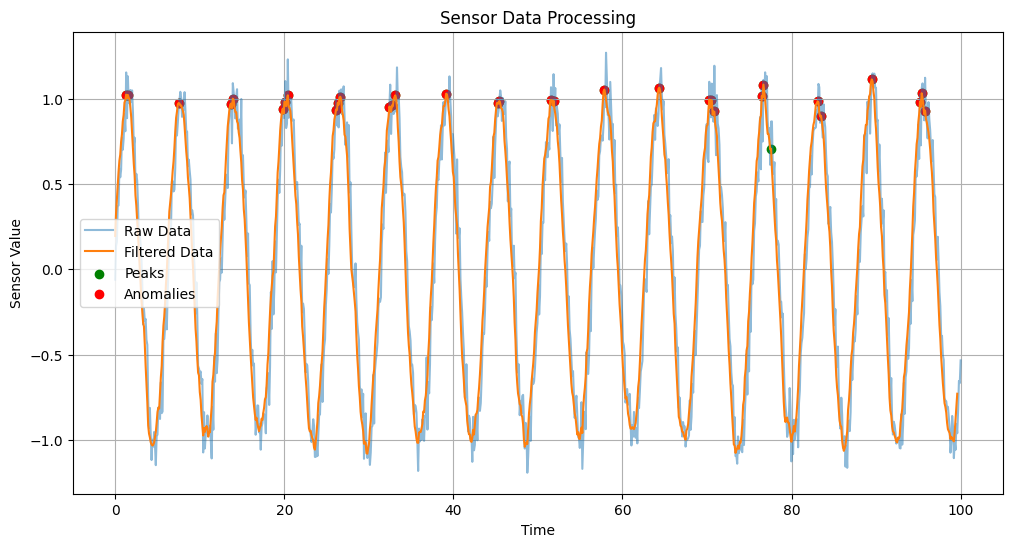

In [55]:
# Run the full pipeline
pipeline_sensor("visualization", num_samples=1000, noise_level=0.1, threshold=0.8)

**Explanation:**

- **Data Collection (`collect_data`)**: Simulate time and sine wave data with added Gaussian noise.
- **Noise Filtering (`filter_noise`)**: Use a simple moving average to smooth the data.
- **Feature Extraction (`extract_features`)**: Find peaks in the filtered data using `scipy.signal.find_peaks`.
- **Anomaly Detection (`detect_anomalies`)**: Identify peaks above a certain threshold as anomalies.
- **Visualization (`visualize`)**: Plot raw data, filtered data, detected peaks, and anomalies.


**Do a study for different noise levels and thresholds:**

We can expand the analysis by examining how varying levels of noise and different sample sizes affect the detection of anomalies.

In [56]:
# Create a new pipeline that terminates at the anomaly detection step (so without visualization)
pipeline_sensor2 = pipeline_sensor.subpipeline(output_names={"anomaly_times", "anomaly_values"})

# Also let's add a function to get the number of detected anomalies


@pipefunc(output_name="num_anomalies")
def count_anomalies(anomaly_times):
    return len(anomaly_times)


pipeline_sensor2.add(count_anomalies)

# Add dimensional axes to the input parameters
pipeline_sensor2.add_mapspec_axis("num_samples", axis="i")
pipeline_sensor2.add_mapspec_axis("noise_level", axis="j")

# Run the subpipeline with different configurations
result = pipeline_sensor2.map(
    inputs={"num_samples": [1000, 500, 1000], "noise_level": [0.05, 0.1, 0.2]},
    run_folder="sensor_map_results",
)

**Plotting Results for Different Noise Levels and Thresholds:**

To better understand the relationships and impacts of noise and sample size on anomaly detection, visualize the results with a heatmap.

In [57]:
# Load and visualize the resulting xarray dataset
import seaborn as sns

from pipefunc.map import load_xarray_dataset

ds = load_xarray_dataset("num_anomalies", run_folder="sensor_map_results")

# Convert data variables to a numpy array for plotting
num_anomalies_data = ds["num_anomalies"].data.astype(int)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    num_anomalies_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=ds["noise_level"].values,
    yticklabels=ds["num_samples"].values,
)

# Add labels
plt.title("Number of Anomalies Heatmap")
plt.xlabel("Noise Level")
plt.ylabel("Number of Samples")

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'seaborn'

### Example: Image Processing Workflow Example with `mapspec`

```{note}
This example uses `scikit-image` for image processing. If you don't have it installed, you can install it using `pip install scikit-image`.
```

In this example, we'll process a batch of images to:

1. **Load and Preprocess**: Convert each image to grayscale to reduce complexity and prepare it for segmentation.
2. **Image Segmentation**: Detect regions of interest within each individual image using an edge detection technique.
3. **Feature Extraction**: Identify and count the number of detected regions for each processed image.
4. **Classification**: Classify each image as "Complex" or "Simple" based on the extracted features.
5. **Result Aggregation**: Summarize the classification results across all images in the batch.

In [ ]:
import numpy as np
from skimage import data, filters, measure
from skimage.color import rgb2gray
from skimage.segmentation import find_boundaries

from pipefunc import Pipeline, pipefunc


# Step 1: Image Loading and Preprocessing
@pipefunc(output_name="gray_image", mapspec="image[n] -> gray_image[n]")
def load_and_preprocess_image(image):
    return rgb2gray(image)


# Step 2: Image Segmentation
@pipefunc(output_name="segmented_image", mapspec="gray_image[n] -> segmented_image[n]")
def segment_image(gray_image):
    return filters.sobel(gray_image)


# Step 3: Feature Extraction
@pipefunc(output_name="feature", mapspec="segmented_image[n] -> feature[n]")
def extract_feature(segmented_image):
    boundaries = find_boundaries(segmented_image > 0.1)
    labeled_image = measure.label(boundaries)
    num_regions = np.max(labeled_image)
    return {"num_regions": num_regions}


# Step 4: Object Classification
@pipefunc(output_name="classification", mapspec="feature[n] -> classification[n]")
def classify_object(feature):
    # Classify image as 'Complex' if the number of regions is above a threshold.
    classification = "Complex" if feature["num_regions"] > 5 else "Simple"
    return classification


# Step 5: Result Aggregation
@pipefunc(output_name="summary")
def aggregate_results(classification):
    simple_count = sum(1 for c in classification if c == "Simple")
    complex_count = len(classification) - simple_count
    return {"Simple": simple_count, "Complex": complex_count}


# Create the pipeline
pipeline_img = Pipeline(
    [
        load_and_preprocess_image,
        segment_image,
        extract_feature,
        classify_object,
        aggregate_results,
    ],
)

# Simulate a batch of images (using built-in scikit-image sample images)
images = [
    data.astronaut(),
    data.coffee(),
    data.coffee(),
]  # Repeat the coffee image to simulate multiple images

# Run the pipeline on the images
results_summary = pipeline_img.map({"image": images})
print("Classification Summary:", results_summary["summary"].output)

**Explanation:**

- **Image Loading and Preprocessing (`load_and_preprocess_image`)**: Converts each individual image to grayscale, ensuring independent processing via `mapspec`.
- **Image Segmentation (`segment_image`)**: Applies Sobel filtering to detect edges and regions of interest in each grayscale image, taking advantage of parallel processing for the batch.
- **Feature Extraction (`extract_feature`)**: Identifies boundaries and counts distinct regions in each segmented image, returning the count as a feature for classification.
- **Object Classification (`classify_object`)**: Classifies each image as "Complex" or "Simple" based on the detected regions relative to a predefined threshold.
- **Result Aggregation (`aggregate_results`)**: Aggregates classifications to provide a summary of "Simple" and "Complex" images across the batch.

**Key Points:**

- **`mapspec`**: Enables independent and parallel processing of each image by defining input-to-output mappings, removing the need for explicit parallel code.
- **Functional Structure**: Utilizes `pipefunc` to manage dependencies and efficiently execute batch image processing, highlighting the framework's ability to handle complex workflows.





### Example: Natural Language Processing Pipeline for Text Summarization

```{note}
This example uses `nltk` for text processing. If you don't have it installed, you can install it using `pip install nltk`.
```

Let's create a simplified NLP workflow for text summarization with steps involving tokenization, keyword extraction, summary generation, and sentiment analysis. This example will demonstrate the use of `pipefunc` to handle dependencies and illustrate `mapspec` by processing multiple texts.

In [ ]:
import nltk
import numpy as np
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize

from pipefunc import Pipeline, pipefunc

nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)


# Step 1: Text Tokenization
@pipefunc(output_name="tokens", mapspec="text[n] -> tokens[n]")
def tokenize_text(text):
    from nltk.corpus import stopwords

    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return filtered_words


# Step 2: Keyword Extraction
@pipefunc(output_name="keywords", mapspec="tokens[n] -> keywords[n]")
def extract_keywords(tokens):
    freq_dist = FreqDist(tokens)
    common_keywords = freq_dist.most_common(5)
    return [word for word, _ in common_keywords]


# Step 3: Summary Generation
@pipefunc(output_name="summary", mapspec="text[n], keywords[n] -> summary[n]")
def generate_summary(text, keywords):
    sentences = sent_tokenize(text)
    important_sentences = [
        sentence
        for sentence in sentences
        if any(keyword in sentence.lower() for keyword in keywords)
    ]
    return " ".join(important_sentences[:2])  # Return the first two important sentences


# Step 4: Sentiment Analysis
@pipefunc(output_name="sentiment", mapspec="summary[n] -> sentiment[n]")
def analyze_sentiment(summary):
    # Simplified sentiment analysis: More positive words = Positive sentiment
    positive_words = {"good", "great", "excellent", "positive", "fortunate"}
    negative_words = {"bad", "terrible", "poor", "negative", "unfortunate"}
    words = set(summary.lower().split())
    sentiment_score = len(words & positive_words) - len(words & negative_words)
    if sentiment_score > 0:
        return "Positive"
    if sentiment_score < 0:
        return "Negative"
    return "Neutral"


# Step 5: Summarization Result Aggregation
@pipefunc(output_name="result_summary")
def aggregate_summarization(sentiment):
    # Convert the sentiment masked array to a list
    sentiment_list = np.array(sentiment).tolist()

    # Count occurrences of each sentiment type
    positive_count = sentiment_list.count("Positive")
    negative_count = sentiment_list.count("Negative")
    neutral_count = sentiment_list.count("Neutral")

    return {"Positive": positive_count, "Negative": negative_count, "Neutral": neutral_count}


# Create the pipeline
pipeline_sentiment = Pipeline(
    [
        tokenize_text,
        extract_keywords,
        generate_summary,
        analyze_sentiment,
        aggregate_summarization,
    ],
)

# Example texts to summarize
texts = [
    "The movie was excellent! The performances were outstanding, and the plot was captivating.",
    "The movie was bad and boring. I found it dull and slow with no gripping moments.",
    "An alright film with a good sense of humor but lacking depth in character development.",
]

# Run the pipeline on texts
results_summary = pipeline_sentiment.map({"text": texts}, parallel=True)
print("Summarization Sentiment Summary:", results_summary["result_summary"].output)

**Explanation:**

- **Text Tokenization (`tokenize_text`)**: Tokenizes each text, removing stop words using a `mapspec` for independent processing.
- **Keyword Extraction (`extract_keywords`)**: Extracts the most frequent words as keywords for each tokenized text.
- **Summary Generation (`generate_summary`)**: Generates a summary by selecting sentences with the most important keywords.
- **Sentiment Analysis (`analyze_sentiment`)**: Analyzes sentiment of summary texts using a set of positive and negative keywords for simplicity.
- **Result Aggregation (`aggregate_summarization`)**: Aggregates sentiments to provide an overall sentiment summary across all texts.

This example showcases the capability of `pipefunc` to manage complex workflows in NLP applications, leveraging `mapspec` to process multiple text inputs efficiently.


### Example: Weather Simulation and Analysis Pipeline with `xarray`

In this example, we'll generate temperature data for multiple cities over several days, compute statistics like mean and variance, and then use `xarray` to load and visualize the results.

In [ ]:
import numpy as np
import pandas as pd

from pipefunc import Pipeline, pipefunc
from pipefunc.map import load_xarray_dataset


# Step 1: Simulate Temperature Data
@pipefunc(output_name="temperature", mapspec="city[i], day[j] -> temperature[i, j]")
def simulate_temperature(city, day):
    np.random.seed(hash(city) % 2**32)  # For reproducibility
    mean_temp = 20 + (hash(city) % 10)  # Base temp varies by city
    temp_variation = 5 * np.sin(day.dayofyear * (2 * np.pi / 365))  # Seasonal variation
    noise = np.random.normal(0, 2)  # Random daily fluctuation
    return float(mean_temp + temp_variation + noise)  # Ensure this is a float


# Step 2: Compute Statistics
@pipefunc(
    output_name=("mean_temp", "variance"),
    mapspec="temperature[i, :] -> mean_temp[i], variance[i]",
    output_picker=dict.__getitem__,
)
def compute_statistics(temperature):
    temp_array = np.array(temperature, dtype=float)  # Ensure it's a numeric array
    mean_temp = np.mean(temp_array)
    var_temp = np.var(temp_array)
    return {"mean_temp": mean_temp, "variance": var_temp}


# Create the pipeline
pipeline_weather = Pipeline([simulate_temperature, compute_statistics])

# Define cities and days
cities = ["New York", "Los Angeles", "Chicago"]
days = pd.date_range("2023-01-01", "2023-01-10")  # 10 days

# Run the pipeline
pipeline_weather.map({"city": cities, "day": days}, run_folder="weather_simulation_results")

# Load and display the xarray dataset
weather_dataset = load_xarray_dataset(run_folder="weather_simulation_results")
display(weather_dataset)

# Plot temperatures for each city
weather_dataset.temperature.astype(float).plot.line(
    x="day",
    hue="city",
    marker="o",
    figsize=(12, 6),
)

**Explanation:**

- **Temperature Simulation (`simulate_temperature`)**: Each city has its synthetic daily temperature calculated using a sinusoidal pattern and noise. The `mapspec` `city[i], day[j] -> temperature[i, j]` allows us to handle city-by-day combinations automatically.

- **Statistics Calculation (`compute_statistics`)**: Computes the mean and variance of the daily temperature, mapping over cities.

- **Automatic `xarray.Dataset`**: The `pipeline.map()` call ensures that the data is structured into an N-dimensional format, representing the outputs naturally as an `xarray.Dataset`.

- **Retrieving with `load_xarray_dataset`**: Quickly access the results organized by city and day indices without manually constructing them.

This showcases `pipefunc`'s powerful ability to manage multi-dimensional computations and data structuring, presenting an efficient workflow for simulating and analyzing temperature variations.

---